In [45]:
from tensorflow.keras.datasets import mnist

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report,accuracy_score
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [47]:
(X_train,y_train),(X_test,y_test)=mnist.load_data()

In [48]:
print(X_train.shape)  #60,000 is the no of images, size is 28*28
print(X_test.shape)  

(60000, 28, 28)
(10000, 28, 28)


In [49]:
#flattening image
X_train=X_train.reshape(-1,28*28).astype(np.float32)
X_test=X_test.reshape(-1,28*28).astype(np.float32)

In [50]:
print(X_train.shape) 
print(X_test.shape)

(60000, 784)
(10000, 784)


In [51]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

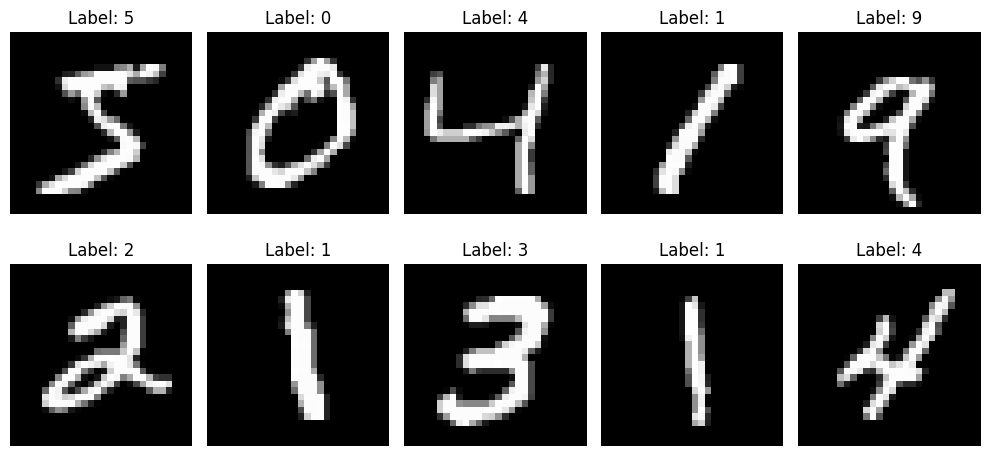

In [52]:
fig, axes=plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
  ax.imshow(X_train[i].reshape(28,28), cmap='gray')
  ax.set_title(f"Label: {y_train[i]}")
  ax.axis('off')
plt.tight_layout()
plt.show()

In [53]:
clf=LinearSVC(dual=False, max_iter=10) #running only 10 iterations

In [54]:
clf.fit(X_train_scaled,y_train)

C:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(dual=False, max_iter=10)

In [55]:
y_pred=clf.predict(X_test_scaled)

In [56]:
print("Accuracy:", accuracy_score(y_test,y_pred))

Accuracy: 0.9163


In [57]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.95      0.98      0.96      1135
           2       0.93      0.88      0.91      1032
           3       0.90      0.91      0.90      1010
           4       0.92      0.93      0.92       982
           5       0.88      0.86      0.87       892
           6       0.93      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.87      0.86      0.87       974
           9       0.90      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.91     10000
weighted avg       0.92      0.92      0.92     10000



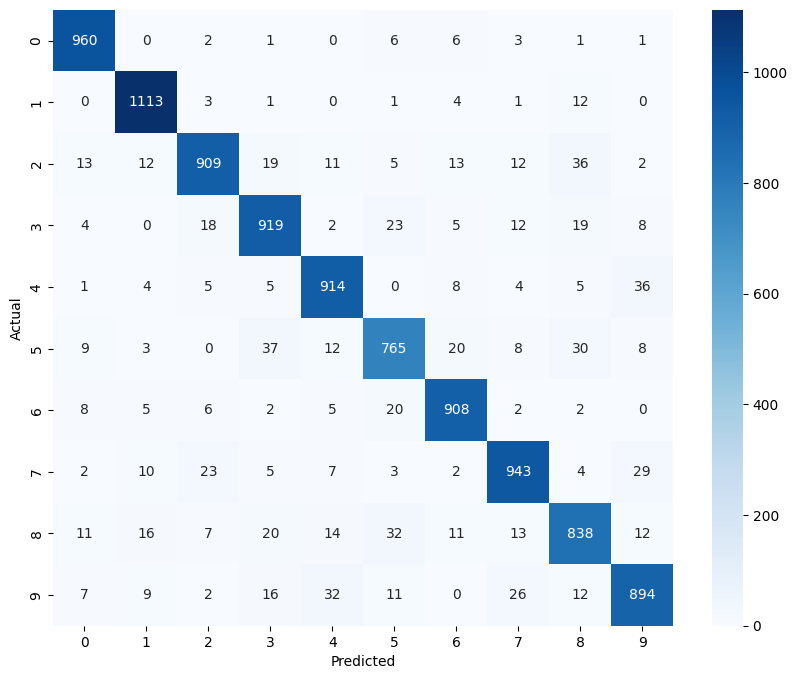

In [60]:
#creating heat map
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), 
            yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


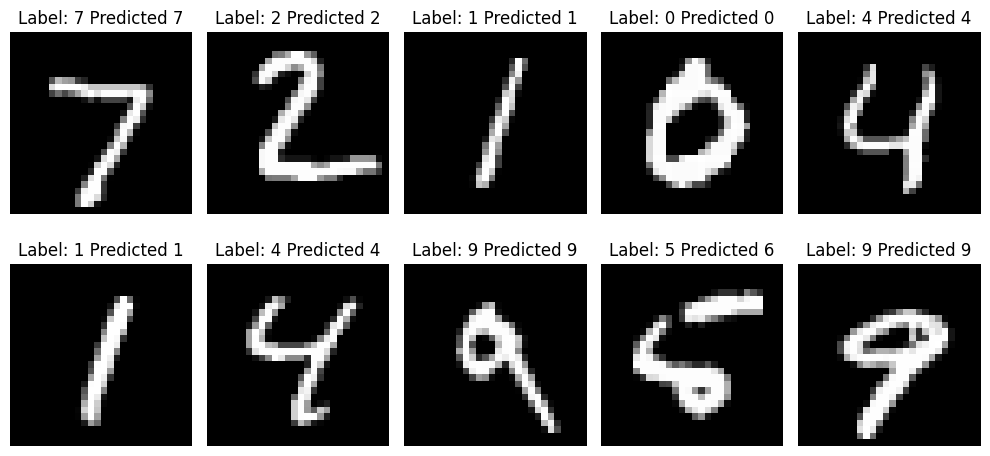

In [61]:
fig, axes=plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
  ax.imshow(X_test[i].reshape(28,28), cmap='gray')
  ax.set_title(f"Label: {y_test[i]} Predicted {y_pred[i]}")
  ax.axis('off')
plt.tight_layout()
plt.show()

In [67]:
#plotting misindentified image
misclassified_indices=np.where(y_test !=y_pred)[0]

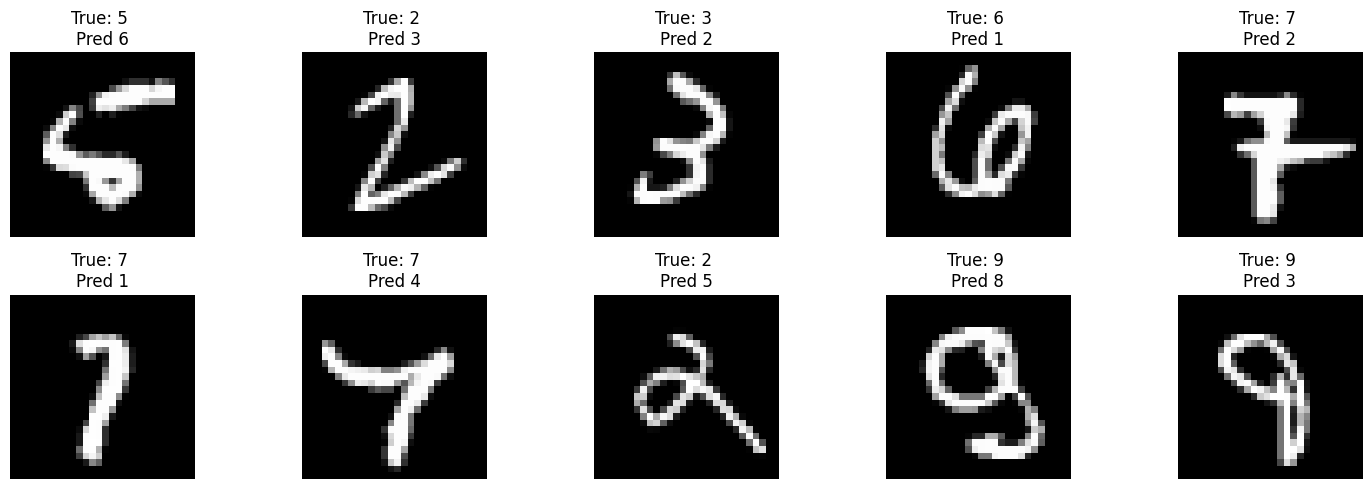

In [68]:
plt.figure(figsize=(15,5))
for i, index in enumerate(misclassified_indices[:10]):
  plt.subplot(2, 5, i+1)
  plt.imshow(X_test[index].reshape(28,28), cmap='gray')
  plt.title(f"True: {y_test[index]} \nPred {y_pred[index]}")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [70]:
weights=clf.coef_
biases=clf.intercept_
print(weights.shape, biases) #10 classes, we have 10 biases

(10, 784) [-2.95258928 -3.69349937 -1.80956423 -1.98311729 -2.72051569 -1.88057979
 -2.71084417 -3.07406188 -1.58691732 -2.36302279]


In [71]:
#writing func to make .h file to import on sifive
with open("svm_model_mnsit.h", "w") as f:
    f.write(f"#define NUM_CLASSES {weights.shape[0]}\n")
    f.write(f"#define NUM_FEATURES {weights.shape[1]}\n\n")

    f.write("double weights[NUM_CLASSES][NUM_FEATURES] = {\n")
    for row in weights:
        f.write("    {" + ", ".join(f"{v:.10f}" for v in row) + "},\n")
    f.write("};\n\n")

    f.write("double bias[NUM_CLASSES] = {" + ", ".join(f"{b:.10f}" for b in biases) + "};\n")

print("✅ Exported SVM model to svm_model.h")


✅ Exported SVM model to svm_model.h


In [74]:
mean=scaler.mean_
scale=scaler.scale_

with open("scaler_mnsit.h", "w") as f:
    f.write(f"#define NUM_FEATURES {len(mean)}\n\n")

    f.write("double mean[NUM_FEATURES] = {\n")
    f.write("    "+", ".join(f"{m:.10f}" for m in mean) + "\n};\n\n")

    f.write("double scale[NUM_FEATURES] = {\n")
    f.write("    "+", ".join(f"{s:.10f}" for s in scale) + "\n};\n")
print("✅ Exported scaler parameters to scaler.h")

✅ Exported scaler parameters to scaler.h


In [79]:
NUM_IMAGES_TO_EXPORT=10

In [80]:
assert X_test.shape[1] == 784
X_sample = X_test[:NUM_IMAGES_TO_EXPORT]
y_sample = y_test[:NUM_IMAGES_TO_EXPORT]

def export_test_images_to_c(images, labels, filename="test_images.h"):
    num_images, num_features = images.shape
    with open(filename, "w") as f:
        f.write("#ifndef TEST_IMAGES_H\n#define TEST_IMAGES_H\n\n")
        f.write(f"#define NUM_TEST_IMAGES {num_images}\n")
        f.write(f"#define NUM_FEATURES {num_features}\n\n")

        # Write image data
        f.write(f"float test_images[NUM_TEST_IMAGES][NUM_FEATURES] = {{\n")
        for img in images:
            f.write("  {" + ", ".join(f"{px:.6f}" for px in img) + "},\n")
        f.write("};\n\n")

        # Write labels (as integers)
        f.write(f"int test_labels[NUM_TEST_IMAGES] = {{\n")
        f.write("  " + ", ".join(str(label) for label in labels))
        f.write("};\n\n")

        f.write("#endif // TEST_IMAGES_H\n")
    print(f"✅ Exported {num_images} test images to {filename}")


In [81]:
export_test_images_to_c(X_sample, y_sample, "test_images.h")

✅ Exported 10 test images to test_images.h
